In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#regression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# classification 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from pycaret.regression import *

In [80]:
# define color palette
agro = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']

In [118]:
df = pd.read_csv('Data/df_preprocessed.csv')
pest_crops = pd.read_csv('Data/pest_crops.csv')

# outliers

### pest

In [5]:
pest_zs = pest_crops.copy()

In [6]:
pest_zs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     1798 non-null   object 
 1   Year                     1798 non-null   int64  
 2   agricultural_use_tonnes  1798 non-null   float64
 3   yield_hg/ha              1798 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 56.3+ KB


In [7]:
# convert year variable to object type, because it's a discrete variable
pest_zs['Year'] = pest_zs['Year'].astype(object)

In [8]:
# DISPLAY OUTLIERS USING ZSCORE

from scipy.stats import zscore 

def outliers_zscore(df):
    for column in df.select_dtypes(include=['float64', 'int64']):
        z_scores = zscore(df[column])
        outliers = df[(z_scores > 3) | (z_scores < -3)]
        print(f"Variable {column} has {len(outliers)} outliers.")

# Call the function passing the DataFrame 'pest_out'
outliers_zscore(pest_zs)

Variable agricultural_use_tonnes has 47 outliers.
Variable yield_hg/ha has 24 outliers.


Repair the outliers of the df pest using z-score as it is less restrictive than using IQR:

In [9]:
def replace_outliers_zscore(df, columns):
    """
    function that replaces the outliers in df using the z-score method.
    """
    for column in columns:
        z_scores = zscore(df[column])
        outliers = df[(z_scores > 3) | (z_scores < -3)]
        df[column] = np.where(z_scores > 3, np.mean(df[column]), df[column])
        df[column] = np.where(z_scores < -3, np.mean(df[column]), df[column])
        
    return df

# Use of the function
numeric_columns = pest_zs.select_dtypes(include=['float64', 'int64']).columns
pest_clean = replace_outliers_zscore(pest_zs, numeric_columns)

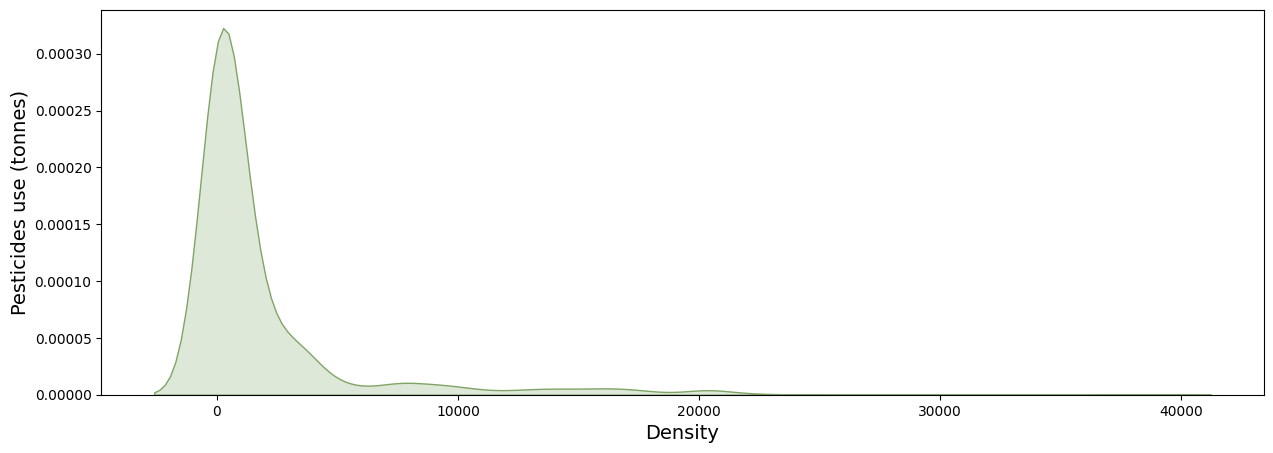

In [10]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=pest_zs, x='agricultural_use_tonnes', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Pesticides use (tonnes)', fontsize=14)
plt.show()

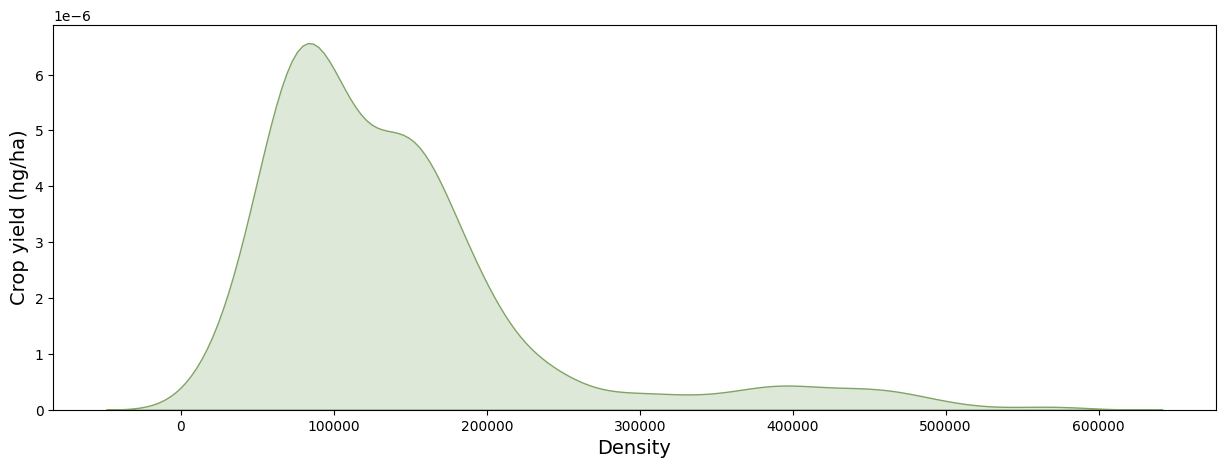

In [11]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=pest_zs, x='yield_hg/ha', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Crop yield (hg/ha)', fontsize=14)
plt.show()

In [13]:
# Save clean csv:
pest_zs.to_csv('Data/pest_clean.csv', index=False)

### df

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  62994 non-null  object 
 1   Crop                  62994 non-null  object 
 2   Year                  62994 non-null  int64  
 3   area_harvested_ha     62994 non-null  float64
 4   production_tonnes     62994 non-null  float64
 5   yield_hg/ha           62994 non-null  float64
 6   avg_rainfall_mm_year  62994 non-null  float64
 7   avg_temp_ºC           62994 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.8+ MB


#### zscore

In [119]:
df_zs = df.copy()

In [120]:
# convert year variable to object type, because it's a discrete variable
df_zs['Year'] = df_zs['Year'].astype(object)

In [121]:
df_zs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  62994 non-null  object 
 1   Crop                  62994 non-null  object 
 2   Year                  62994 non-null  object 
 3   area_harvested_ha     62994 non-null  float64
 4   production_tonnes     62994 non-null  float64
 5   yield_hg/ha           62994 non-null  float64
 6   avg_rainfall_mm_year  62994 non-null  float64
 7   avg_temp_ºC           62994 non-null  float64
dtypes: float64(5), object(3)
memory usage: 3.8+ MB


In [122]:
# DISPLAY OUTLIERS USING ZSCORE

from scipy.stats import zscore 

def outliers_zscore(df):
    for column in df.select_dtypes(include=['float64', 'int64']):
        z_scores = zscore(df[column])
        outliers = df[(z_scores > 3) | (z_scores < -3)]
        print(f"Variable {column} has {len(outliers)} outliers.")

# Call the function passing the DataFrame 'pest_out'
outliers_zscore(df_zs)

Variable area_harvested_ha has 555 outliers.
Variable production_tonnes has 350 outliers.
Variable yield_hg/ha has 556 outliers.
Variable avg_rainfall_mm_year has 0 outliers.
Variable avg_temp_ºC has 830 outliers.


In [123]:
def replace_outliers_zscore(df, columns):
    """
    function that replaces the outliers in df using the z-score method.
    """
    for column in columns:
        z_scores = zscore(df[column])
        outliers = df[(z_scores > 3) | (z_scores < -3)]
        df[column] = np.where(z_scores > 3, np.mean(df[column]), df[column])
        df[column] = np.where(z_scores < -3, np.mean(df[column]), df[column])
        
    return df

# Use of the function
numeric_columns = df_zs.select_dtypes(include=['float64', 'int64']).columns
df_clean = replace_outliers_zscore(df_zs, numeric_columns)

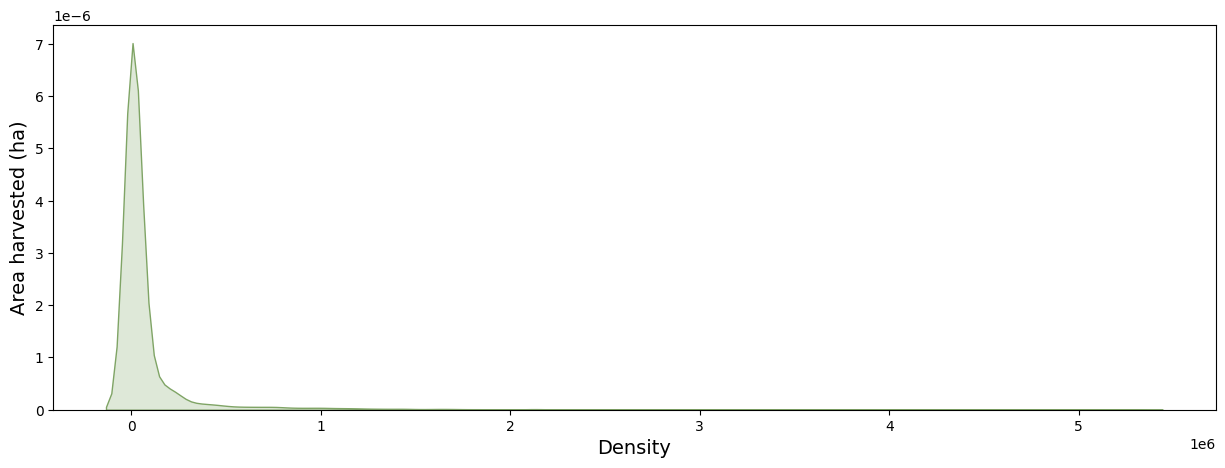

In [88]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_clean, x='area_harvested_ha', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Area harvested (ha)', fontsize=14)
plt.show()

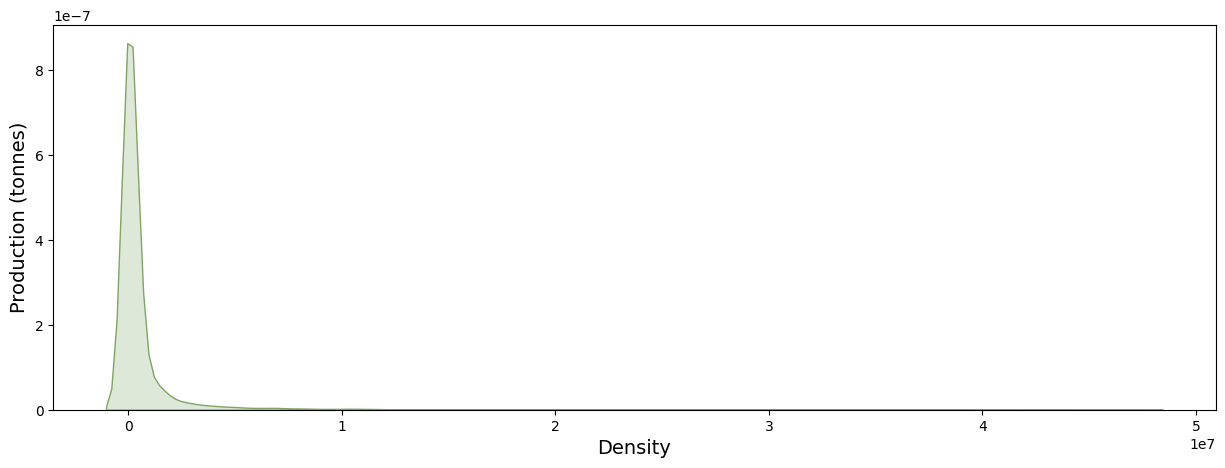

In [89]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_clean, x='production_tonnes', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Production (tonnes)', fontsize=14)
plt.show()

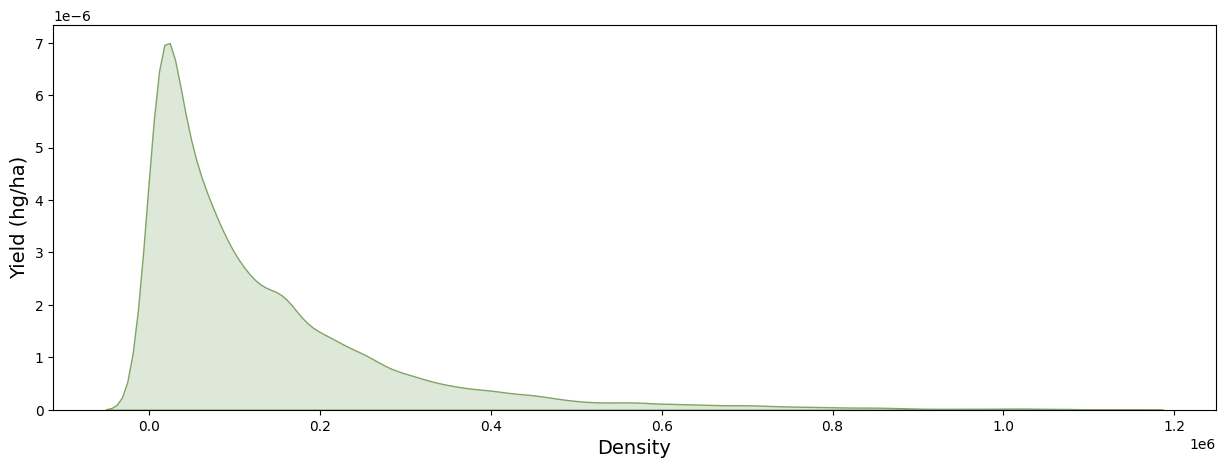

In [90]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_clean, x='yield_hg/ha', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Yield (hg/ha)', fontsize=14)
plt.show()

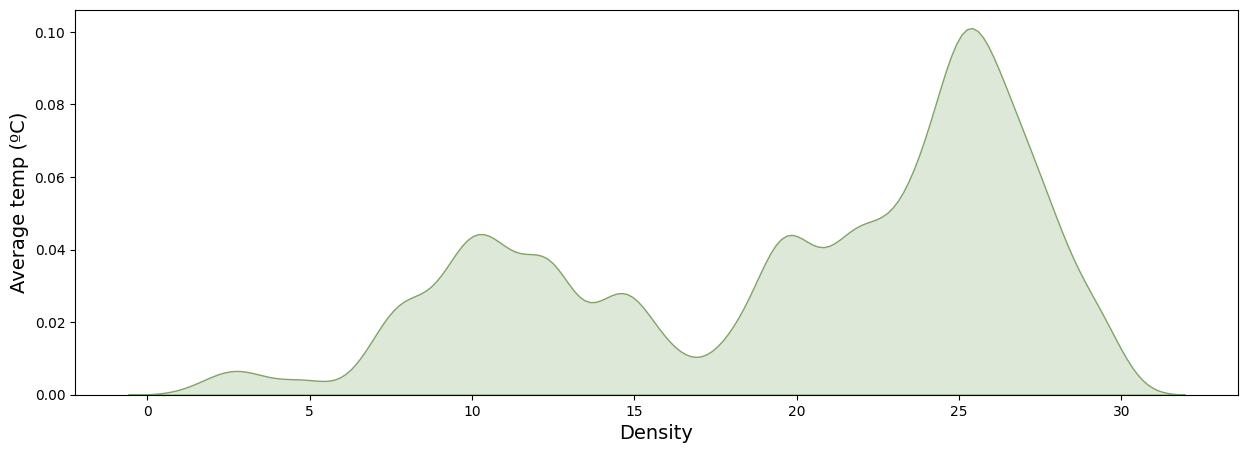

In [91]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_clean, x='avg_temp_ºC', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Average temp (ºC)', fontsize=14)
plt.show()

In [124]:
# Save clean csv:
df_zs.to_csv('Data/df_clean.csv', index=False)

# modelling

In [2]:
df = pd.read_csv('Data/df_clean.csv')

## correlation analysis

### df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  62994 non-null  object 
 1   Crop                  62994 non-null  object 
 2   Year                  62994 non-null  int64  
 3   area_harvested_ha     62994 non-null  float64
 4   production_tonnes     62994 non-null  float64
 5   yield_hg/ha           62994 non-null  float64
 6   avg_rainfall_mm_year  62994 non-null  float64
 7   avg_temp_ºC           62994 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.8+ MB


In [4]:
# encode the object type variables to analize the correlation

from sklearn.preprocessing import LabelEncoder

# create an instance of the encoder
encoder = LabelEncoder()

for columns in df.columns:
    if df[columns].dtype == 'object':
        df[columns] = encoder.fit_transform(df[columns])

In [5]:
# save encoder 
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [6]:
# Spearman's method 
corr = df.corr(method='spearman')

In [7]:
# Analysis of variables highly correlated with target var (yield)

threshold = 0.1
corr[(corr>threshold)|(corr<-threshold)]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
Area,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crop,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Year,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
area_harvested_ha,NaN,NaN,NaN,1.000000,0.880809,-0.164261,NaN,NaN
production_tonnes,NaN,NaN,NaN,0.880809,1.000000,0.253534,-0.102779,-0.111112
yield_hg/ha,NaN,NaN,NaN,-0.164261,0.253534,1.000000,NaN,-0.121341
avg_rainfall_mm_year,NaN,NaN,NaN,NaN,-0.102779,NaN,1.000000,0.232718
avg_temp_ºC,NaN,NaN,NaN,NaN,-0.111112,-0.121341,0.232718,1.000000


In [8]:
# create a df with the variables that have a high correlation with the target variable (yield) + target var  + Crop
df_regression = df[['Crop','area_harvested_ha','production_tonnes',
		 'avg_temp_ºC',
		 'yield_hg/ha']]

In [9]:
# create a df for the classification model --> target: crop
df_classification = df[['Area','area_harvested_ha',
		 'avg_rainfall_mm_year',
		 'avg_temp_ºC','Crop']]

In [32]:
crops = ['Wheat', 'Rice', 'Barley', 'Maize (corn)', 'Millet', 'Potatoes',
       'Sugar cane', 'Other pulses n.e.c.', 'Sunflower seed',
       'Seed cotton, unginned',
       'Onions and shallots, dry (excluding dehydrated)',
       'Other vegetables, fresh n.e.c.', 'Oranges', 'Apples', 'Pears',
       'Peaches and nectarines', 'Plums and sloes', 'Grapes',
       'Watermelons', 'Cantaloupes and other melons',
       'Other fruits, n.e.c.', 'Oats', 'Beans, dry', 'Soya beans',
       'Cabbages', 'Lettuce and chicory', 'Tomatoes',
       'Cauliflowers and broccoli', 'Pumpkins, squash and gourds',
       'Cucumbers and gherkins', 'Eggplants (aubergines)',
       'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)',
       'Green garlic', 'Other beans, green', 'Peas, green',
       'Carrots and turnips', 'Lemons and limes', 'Strawberries',
       'Unmanufactured tobacco', 'Sorghum', 'Peas, dry',
       'Groundnuts, excluding shelled', 'Bananas',
       'Pomelos and grapefruits', 'Sweet potatoes', 'Cassava, fresh',
       'Mangoes, guavas and mangosteens', 'Pineapples', 'Coffee, green',
       'Coconuts, in shell']

In [135]:
# GUARDAR EN JSON
# # Save country list in a JSON file
# with open('json/crops.json', 'w') as f:
#     json.dump(crops, f)

In [10]:
#Save csv
df_regression.to_csv('Data/df_ml_regression.csv', index=False)

In [11]:
#Save csv
df_classification.to_csv('Data/df_ml_classification.csv', index=False)

## Regression modelling and model evaluation

- Data split

In [12]:
# assign the independent variables and the dependent variable. Our target variable is yield
X = df_regression.drop(['yield_hg/ha'], axis=1)
y = df_regression['yield_hg/ha']

In [13]:
# split the data into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=357) 

In [14]:
# Normalisation

#Initiating the scaler
scaler = StandardScaler()
 
#Normalise training variables
X_train_scaled = scaler.fit_transform(X_train)
 
#We apply the same normalisation to the test 
X_test_scaled = scaler.transform(X_test)

In [15]:
# save scaler
joblib.dump(scaler, 'scaler_regr.pkl')

['scaler_regr.pkl']

Traning models:

- ElasticNet

In [38]:
#Initialise model and parameters
alpha = 0.1 
l1_ratio = 0.1 
#Instantiate the model
model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)
#train model
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse_ElasticNet = mse(y_test, y_pred)
mse_ElasticNet**.5

142035.85468194238

- Stochastic Gradient Descent

In [39]:
#Initialise model and parameters
penalty = 'elasticnet' 
alpha = .1 
l1_ratio = .1 
#Instantiate the model
model = SGDRegressor(penalty = penalty, alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)
#train model
model.fit(X_train_scaled, y_train)
mse_SGDRegressor = mse(y_test,model.predict(X_test_scaled))
print(mse_SGDRegressor**.5)

142226.83396693942


- Random Forest

In [54]:
#Initialise model and parameters
n_estimators = 200 
criterion = 'squared_error' 
max_depth = None 
min_samples_split = 2 
verbose = 1 
#Instantiate the model
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)
#train model
model.fit(X_train_scaled, y_train)
mse_RF = mse(y_test,model.predict(X_test_scaled))
print(mse_RF**.5)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


25052.45799194902


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


- Boosting: *Gradient Descent*

In [52]:
#Initialise model and parameters
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10
#convert the data to DMatrix format.
train_data = xgb.DMatrix(X_train_scaled, label=y_train)
test_data = xgb.DMatrix(X_test_scaled, label=y_test)
##Instantiate the model and train model
model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = mse(y_test,model.predict(test_data))
print(mse_XGB**0.5)

103293.22268918318


Compare models:

Text(0.5, 0, 'Model')

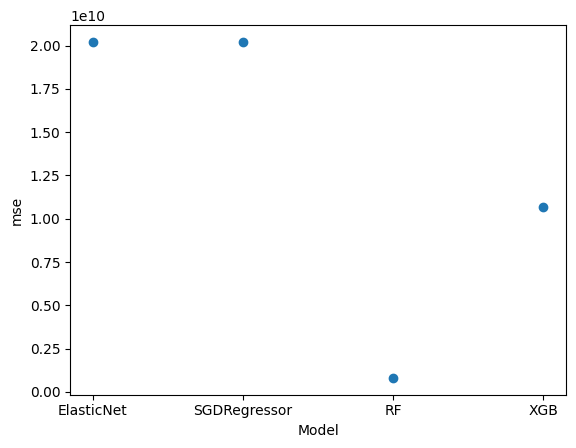

In [53]:
mse = [mse_ElasticNet, mse_SGDRegressor, mse_RF, mse_XGB] 
plt.scatter(['ElasticNet', 'SGDRegressor', 'RF', 'XGB'], mse) 
plt.ylabel('mse')
plt.xlabel('Model')

Best Model: Random Forest

In [55]:
#save best model

joblib.dump(model, 'models/yield_RF.pkl') 

['models/yield_RF.pkl']

---
### Fast Machine Learning (Pycaret)

In [36]:
df = pd.read_csv('Data/df_ml_regression.csv')

In [37]:
#Set the target: yield
setup = setup(data = df, target = 'yield_hg/ha', session_id = 357)	

,Description,Value
0,Session id,357
1,Target,yield_hg/ha
2,Target type,Regression
3,Original data shape,"(62994, 4)"
4,Transformed data shape,"(62994, 4)"
5,Transformed train set shape,"(44095, 4)"
6,Transformed test set shape,"(18899, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [38]:
# compare models and choose the best
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:03:22
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4166.2087,948014410.0786,30697.9579,0.9612,0.1051,0.0307,6.4730
et,Extra Trees Regressor,4309.7725,960885255.9972,30824.3185,0.9607,0.1342,0.0476,3.4430
xgboost,Extreme Gradient Boosting,9497.7277,1014968812.8000,31735.9510,0.9583,0.2641,0.1456,0.1970
lightgbm,Light Gradient Boosting Machine,11362.6446,1262634577.5066,35449.0380,0.9483,0.3042,0.2361,0.2760
dt,Decision Tree Regressor,6412.1133,1591864998.7079,39598.1572,0.9345,0.1226,0.0480,0.1410
knn,K Neighbors Regressor,16535.0730,4179539020.8000,64603.4820,0.8285,0.2837,0.1890,0.0520
gbr,Gradient Boosting Regressor,29239.9353,4201029000.5752,64737.0481,0.8279,0.5672,0.5848,2.2470
llar,Lasso Least Angle Regression,105851.2109,23138914508.8000,152063.8000,0.0505,1.4217,4.4513,0.0230
lar,Least Angle Regression,105851.2102,23138915123.2000,152063.8016,0.0505,1.4217,4.4513,0.0240
en,Elastic Net,105854.4781,23138926592.0000,152063.8516,0.0505,1.4222,4.4527,0.0680


RF is also the best model by PyCaret

## Classification modelling and model evaluation

- Data split

In [16]:
# assign the independent variables and the dependent variable. Our target variable is yield
X = df_classification.drop(['Crop'], axis=1)
y = df_classification['Crop']

# split the data into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .25, random_state=7)

In [17]:
# Normalisation

#Initiating the scaler
scaler = StandardScaler()
 
#Normalise training variables
X_train_scaled = scaler.fit_transform(X_train)
 
#We apply the same normalisation to the test 
X_test_scaled = scaler.transform(X_test)

In [18]:
# save scaler
joblib.dump(scaler, 'scaler_classif.pkl')

['scaler_classif.pkl']

- Logistic model

In [19]:
# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(max_iter =1000) # Si aumentamos a 10k, se quita el warning. Si queremos usar un modelo potente, usar Colab
#Entrenamos en los datos
logreg.fit(X_train, y_train)  
#Predecimos
y_pred = logreg.predict(X_test)
# Classification report
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       278
           1       1.00      0.00      0.00       338
           2       1.00      0.00      0.00       307
           3       1.00      0.00      0.00       346
           4       1.00      0.00      0.00       428
           5       1.00      0.00      0.00       271
           6       1.00      0.00      0.00       374
           7       1.00      0.00      0.00       266
           8       1.00      0.00      0.00       280
           9       1.00      0.00      0.00       363
          10       1.00      0.00      0.00       233
          11       1.00      0.00      0.00       234
          12       1.00      0.00      0.00       384
          13       1.00      0.00      0.00       264
          14       1.00      0.00      0.00       276
          15       1.00      0.00      0.00       292
          16       1.00      0.00      0.00       326
          17       1.00    

- KNN regression

In [69]:
#Parámetros
weights = 'distance'
p = 2
n_neighbours = 5
#Modelo
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.35      0.33       278
           1       0.35      0.37      0.36       338
           2       0.22      0.21      0.22       307
           3       0.22      0.22      0.22       346
           4       0.33      0.36      0.34       428
           5       0.26      0.25      0.25       271
           6       0.32      0.34      0.33       374
           7       0.27      0.27      0.27       266
           8       0.31      0.33      0.32       280
           9       0.30      0.32      0.31       363
          10       0.47      0.51      0.49       233
          11       0.37      0.38      0.38       234
          12       0.32      0.33      0.32       384
          13       0.38      0.39      0.38       264
          14       0.34      0.39      0.36       276
          15       0.33      0.36      0.35       292
          16       0.28      0.27      0.28       326
          17       0.37    

In [20]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.51      0.50      0.51       278
           1       0.59      0.58      0.58       338
           2       0.65      0.64      0.64       307
           3       0.45      0.44      0.44       346
           4       0.41      0.38      0.40       428
           5       0.33      0.31      0.32       271
           6       0.44      0.43      0.43       374
           7       0.51      0.56      0.53       266
           8       0.38      0.37      0.38       280
           9       0.40      0.39      0.39       363
          10       0.66      0.67      0.67       233
          11       0.59      0.62      0.61       234
          12       0.37      0.39      0.38       384
          13       0.44      0.45      0.44       264
          14       0.59      0.60      0.59       276
          15       0.44      0.45      0.45       292
          16       0.48      0.49      0.49       326
          17       0.40    

In [21]:
#save best model

joblib.dump(RFC, 'models/crop_RF.pkl') 

['models/crop_RF.pkl']

---
### Fast Machine Learning (Pycaret)

In [76]:
df = pd.read_csv('Data/df_ml_classification.csv')

In [78]:
#Set the target: crop
setup = setup(data = df, target = 'Crop', session_id = 357)

,Description,Value
0,Session id,357
1,Target,Crop
2,Target type,Regression
3,Original data shape,"(62994, 5)"
4,Transformed data shape,"(62994, 5)"
5,Transformed train set shape,"(44095, 5)"
6,Transformed test set shape,"(18899, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [79]:
# compare models and choose the best
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,8.7537,154.7283,12.4383,0.2700,0.7627,0.9963,6.1100
xgboost,Extreme Gradient Boosting,10.4007,158.2680,12.5800,0.2535,0.8305,1.2912,0.3810
lightgbm,Light Gradient Boosting Machine,11.4897,181.7604,13.4815,0.1427,0.8830,1.4810,0.3990
et,Extra Trees Regressor,8.7241,184.7760,13.5922,0.1283,0.8131,0.9455,2.6510
knn,K Neighbors Regressor,11.1085,201.3234,14.1883,0.0504,0.8710,1.3449,0.0790
gbr,Gradient Boosting Regressor,12.2410,203.5479,14.2667,0.0400,0.9150,1.5936,1.9380
ada,AdaBoost Regressor,12.4881,210.4306,14.5058,0.0075,0.9240,1.6242,0.1830
lar,Least Angle Regression,12.5324,211.8098,14.5533,0.0010,0.9243,1.6212,0.0670
en,Elastic Net,12.5311,211.8154,14.5535,0.0010,0.9244,1.6207,0.1090
ridge,Ridge Regression,12.5324,211.8098,14.5533,0.0010,0.9243,1.6212,0.0440


Taking into account the MSE error, the random forest model again gives the best results.